# Training the model

In this notebook I will be building and training an classification model to recognise handwritten digits from the MNIST dataset, using **PyTorch**. This was written by me, Nick. No steal pls.

In [9]:
import torch, torchvision
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

## The dataset

I will be using `torchvision.datasets.MNIST` class to download the training and testing datasets. It may take a while to download it, it is 64 MiB. Big boy!

In [10]:
train_dataset = torchvision.datasets.MNIST(
    root=".datasets",
    download=True,
    train=False,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_dataset = torchvision.datasets.MNIST(
    root=".datasets",
    download=True,
    train=False,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

Now we turn it into a Python iterable using `torch.utils.data.DataLoader` class.

In [11]:
import torch.utils.data

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False
)

## Exploratory data analysis

Also known as EDA! I learned it from my Udemy courses! We're gonna be "becoming one with the data" or whatever that means.

Data batch shape: (32, 1, 28, 28) - (batch, channels, width, height)
Label batch shape: (32,)


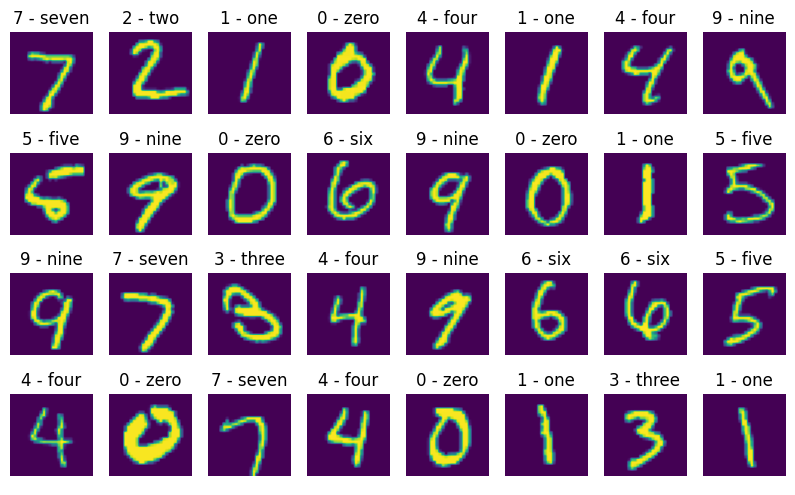

In [24]:
data_batch, label_batch = next(iter(test_dataloader))

print("Data batch shape:", tuple(data_batch.shape), "- (batch, channels, width, height)")
print("Label batch shape:", tuple(label_batch.shape))

plt.figure(figsize=(10, 6))
plt.axis(False)
class_names = test_dataset.classes
for index, (image, label) in enumerate(zip(data_batch, label_batch)):
    label = class_names[label]
    plt.subplot(4, len(data_batch) // 4, index+1)
    plt.title(label)
    plt.imshow(image.reshape(28, 28))
    plt.axis(False)

Ok that is enough of that. Now we know there are indeed numbers in the dataset.

## Building model

Let's build our convolutional neural network. Yes we're gonna be using some convolution layers. The architecture I will be following is called **TinyVGG**.

In [13]:
class TinyVGG(nn.Module):
    def __init__(self, in_shape, hidden_units, out_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_shape, out_channels=hidden_units, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4*4, out_features=out_shape),
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.classifier(
            self.conv_block_2(
                self.conv_block_1(X)
            )
        )

In [14]:
model = TinyVGG(
    in_shape=1,
    hidden_units=30,
    out_shape=len(class_names)
)

In [15]:
# Dummy forward pass
model.eval()
with torch.inference_mode():
    y_logits = model.forward(data_batch)
print(y_logits[0])

tensor([0.4969, 0.4891, 0.5023, 0.4932, 0.4775, 0.4945, 0.4944, 0.5016, 0.4989,
        0.5025])


## Training the model

Using our trusty Cross-entropy loss function and Adam optimizer, we can train the model for 10 iterations/epochs to try and decrease our loss.

In [17]:
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

for epoch in range(epochs):
    # The training iteration
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_logits = model.forward(X)
        loss = loss_fn(y_logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # The testing iteration - this is not required but it is useful to see what's going on
    total_loss = 0
    for batch, (X, y) in enumerate(test_dataloader):
        model.eval()
        with torch.inference_mode():
            y_logits = model.forward(X)
            total_loss += loss_fn(y_logits, y)
            
    print(f"Epoch: {epoch+1} | Average test loss: {total_loss / batch}")

Epoch: 1 | Average test loss: 1.5218418836593628
Epoch: 2 | Average test loss: 1.5130527019500732
Epoch: 3 | Average test loss: 1.5022035837173462
Epoch: 4 | Average test loss: 1.497173547744751
Epoch: 5 | Average test loss: 1.4962222576141357
Epoch: 6 | Average test loss: 1.5026103258132935
Epoch: 7 | Average test loss: 1.4943139553070068
Epoch: 8 | Average test loss: 1.492933988571167
Epoch: 9 | Average test loss: 1.4925649166107178
Epoch: 10 | Average test loss: 1.4862473011016846
Epoch: 11 | Average test loss: 1.4866799116134644
Epoch: 12 | Average test loss: 1.488335132598877
Epoch: 13 | Average test loss: 1.4845397472381592
Epoch: 14 | Average test loss: 1.4819830656051636
Epoch: 15 | Average test loss: 1.481873631477356
Epoch: 16 | Average test loss: 1.4827147722244263
Epoch: 17 | Average test loss: 1.4877660274505615
Epoch: 18 | Average test loss: 1.4831655025482178
Epoch: 19 | Average test loss: 1.4791966676712036
Epoch: 20 | Average test loss: 1.4836324453353882


## Evaluating the model

Let's just check the accuracy. The loss has only lowered by tiny amount, but even that can have large changes on the accuracy.

In [25]:
from torchmetrics import Accuracy

y_preds = []
y_true = []

for batch, (X,  y) in enumerate(test_dataloader):
    model.eval()
    with torch.inference_mode():
        y_logits = model.forward(X)
        y_pred = y_logits.argmax(dim=1)
        y_preds = y_preds + y_pred.tolist()
        y_true = y_true + y.tolist()

accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names))
accuracy = accuracy_fn(torch.Tensor(y_preds), torch.Tensor(y_true))

print(f"Model accuracy on testing data: {accuracy*100:.2f}%")

Model accuracy on testing data: 98.36%


## Save/export the model

We can use PyTorch's bultin functionality to save our model, so that we can use it in the graphical program.

In [27]:
torch.save(model, "tinyvgg-trained.pth")

We can double check the accuracy on loaded model.

In [28]:
model_loaded = torch.load("tinyvgg-trained.pth")

y_preds = []
y_true = []

for batch, (X,  y) in enumerate(test_dataloader):
    model_loaded.eval()
    with torch.inference_mode():
        y_logits = model_loaded.forward(X)
        y_pred = y_logits.argmax(dim=1)
        y_preds = y_preds + y_pred.tolist()
        y_true = y_true + y.tolist()

accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names))
accuracy = accuracy_fn(torch.Tensor(y_preds), torch.Tensor(y_true))

print(f"Model accuracy on testing data: {accuracy*100:.2f}%")

Model accuracy on testing data: 98.36%


Great! We are done here!